## Anomaly Detection- windowed method 

In [86]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout

Importing the dataset

In [87]:
data = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [88]:
instances_of_anomaly= [["2014-10-30 15:30:00.000000","2014-11-03 22:30:00.000000"],
        ["2014-11-25 12:00:00.000000","2014-11-29 19:00:00.000000"],
        ["2014-12-23 11:30:00.000000","2014-12-27 18:30:00.000000"],
        ["2014-12-29 21:30:00.000000","2015-01-03 04:30:00.000000"],
        ["2015-01-24 20:30:00.000000","2015-01-29 03:30:00.000000"]]

In [89]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

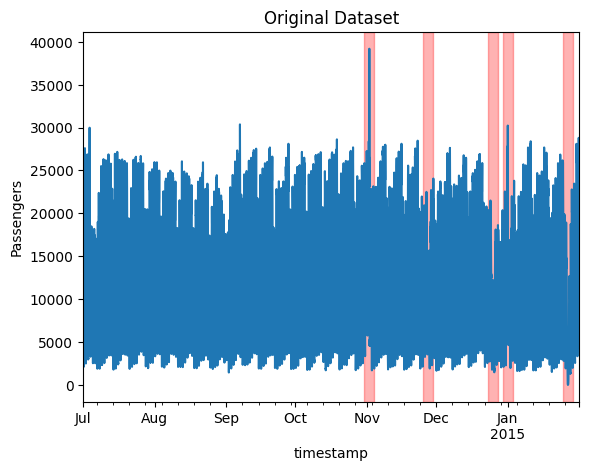

In [90]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [91]:
# Splitting to train and test
test_ratio =0.45
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]
data_with_anomaly= data_with_anomaly.iloc[int(len(data) * (1 - test_ratio)) :]

In [92]:
tr_data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2014-10-27 03:30:00,1707
2014-10-27 04:00:00,2138
2014-10-27 04:30:00,2406


Normailzing the training set 

In [93]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 5676


Function to create the windowed data

In [94]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

Each sample is half an jour apart, so 336 samples accounts for a week

In [95]:
step_size = 500

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (5177, 500, 1)


VAE model

In [96]:
# # Reparameterization trick
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
#     return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [97]:
# class VAELossLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(VAELossLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         x, x_decoded_mean, z_mean, z_log_var = inputs
#         # Reshape inputs to have the same shape
#         x = tf.reshape(x, tf.shape(x_decoded_mean))
#         # compute the average MSE error, then scale it up, i.e. simply sum on all axes
#         reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
#         # compute the KL loss
#         kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
#         # return the average loss over all 
#         total_loss = tf.reduce_mean(reconstruction_loss + 0.05*kl_loss)    
#         self.add_loss(total_loss)
#         return x  # Dummy output


In [98]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

In [99]:
class VAELossLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Reshape inputs to have the same shape
        x = tf.reshape(x, tf.shape(x_decoded_mean))
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output



In [100]:
# Define VAE loss function
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # Reshape inputs to have the same shape
    x = tf.reshape(x, tf.shape(x_decoded_mean))
    
    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
    
    # Compute KL divergence
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    
    # Combine reconstruction loss and KL divergence
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    return total_loss

# Encoder
latent_dim = 8  # Dimensionality of the latent space
encoder_inputs = Input(shape=(train.shape[1], train.shape[2]))
x = layers.Conv1D(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(encoder_inputs)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Use Lambda layer to sample from the latent distribution
z = layers.Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(train.shape[1]*16, activation='relu')(latent_inputs)
x = layers.Reshape((int(train.shape[1]/4), 64))(x)  # Adjusted reshape operation
x = layers.Conv1DTranspose(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
decoder_outputs = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)


# Instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Instantiate VAE model
outputs = decoder(encoder(encoder_inputs)[2])



vae_loss_layer = VAELossLayer()([encoder_inputs, outputs, z_mean, z_log_var])

#vae = keras.Model(encoder_inputs, outputs, name="vae")
vae = keras.Model(encoder_inputs, [outputs, vae_loss_layer], name='vae')

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [101]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 500, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 250, 32)   │        256 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 250, 32)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 125, 16)   │      3,600 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     35,872 │ input_layer_6[0]… │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2000)      │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 500, 1)    │     90,081 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │     16,008 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │     16,008 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_3    │ (None, 500, 1)    │          0 │ input_layer_6[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,953 (492.00 KB)

 Trainable params: 125,953 (492.00 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
# model = keras.Sequential(
#     [
#         layers.Input(shape=(train.shape[1], train.shape[2])),
#         layers.Conv1D(
#             filters=32,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(
#             filters=16,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Conv1DTranspose(
#             filters=16,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(
#             filters=32,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()


In [103]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 52185.6172 - val_loss: 21309.5918
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 20280.9941 - val_loss: 13672.7344
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12306.9775 - val_loss: 7784.6719
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7999.4121 - val_loss: 5874.7388
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6416.6411 - val_loss: 4768.9600
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5303.0225 - val_loss: 3791.6907
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4646.0098 - val_loss: 3122.7070
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4076.8240 - val_loss: 2959.8887
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3656.6704 - val_loss: 2539.5896
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3333.3687 - val_loss: 2353.3306
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3111.8716 - val_loss: 2002.4236
Epo

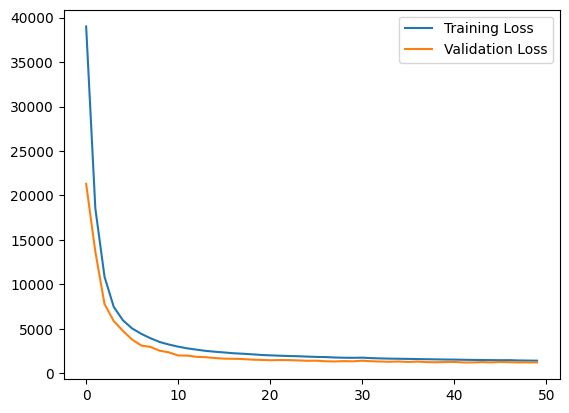

In [104]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
(5177, 1)


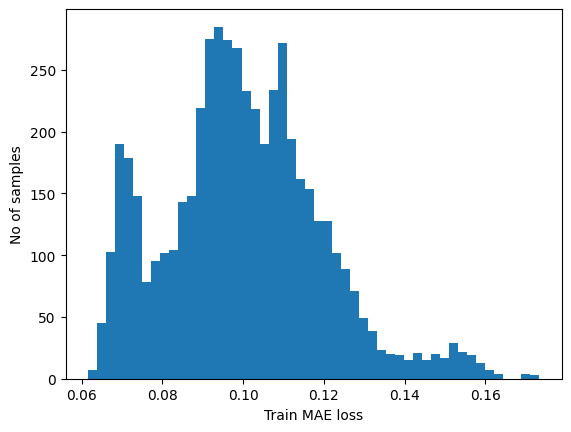

Reconstruction error threshold:  0.17336322326750672


In [105]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [106]:
print(train_pred.shape)

(5177, 500, 1)


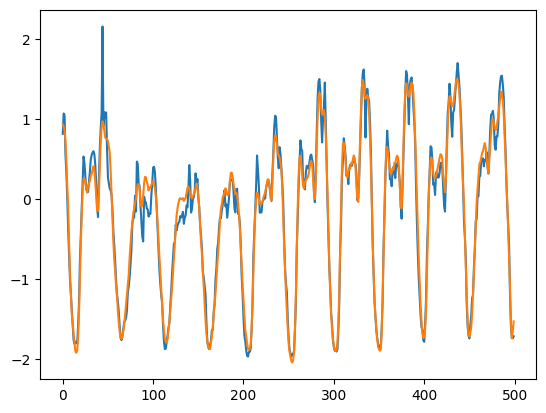

In [107]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

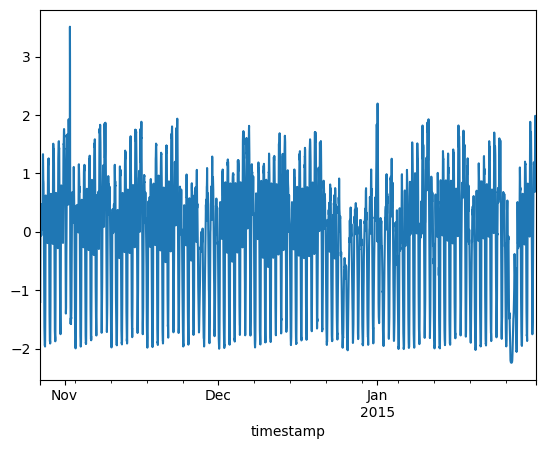

Test input shape:  (4145, 500, 1)
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(4145, 1)


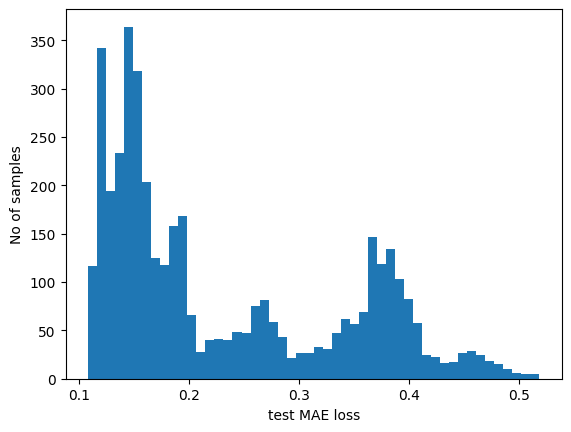

Number of anomaly samples:  2262
Indices of anomaly samples:  (array([ 987,  988,  993, ..., 4142, 4143, 4144], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [108]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [109]:
# anomalous_data_indices = []
# for ind in range(len(anomalies)):
#     if anomalies[ind]:
#         anomalous_data_indices.append(ind)

In [110]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [111]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912

In [112]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-11-27 08:00:00,7076
2014-11-27 08:30:00,7813
2014-11-27 09:00:00,8365
2014-11-27 09:30:00,9013
2014-11-27 10:00:00,9695
...,...
2015-01-07 10:00:00,15690
2015-01-07 10:30:00,16091
2015-01-07 11:00:00,14981


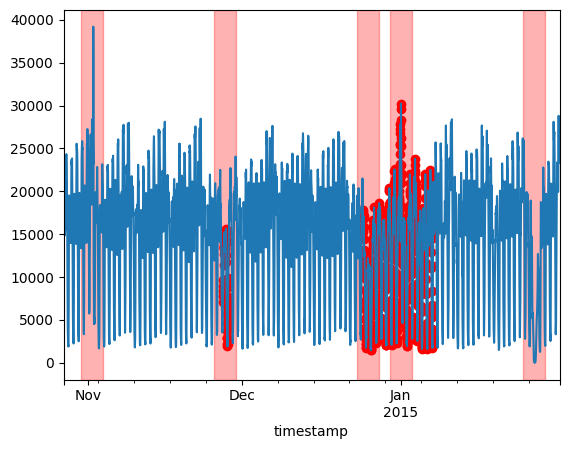

In [113]:
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()